In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from osgeo import gdal

%matplotlib inline

In [109]:
img_rows, img_cols, channels = 64, 64, 2
batch_size = 32
original_img_size = (img_rows, img_cols, channels)
latent_dim = 16
intermediate_dim = 64
epsilon_std = 1.0

x = Input(batch_shape=(batch_size,) + original_img_size)

conv_1 = Conv2D(64, 3, padding='same', activation='relu')(x)
maxp_1 = MaxPooling2D((2, 2), padding='same')(conv_1)#32

conv_2 = Conv2D(64, 3, padding='same', activation='relu')(maxp_1)
maxp_2 = MaxPooling2D((2, 2), padding='same')(conv_2)#16

conv_3 = Conv2D(64, 3, padding='same', activation='relu')(maxp_2)
maxp_3 = MaxPooling2D((2, 2), padding='same')(conv_3)#8

conv_4 = Conv2D(32, 3, padding='same', activation='relu')(maxp_3)
maxp_4 = MaxPooling2D((2, 2), padding='same')(conv_4)#4

conv_5 = Conv2D(16, 3, padding='same', activation='relu')(maxp_4)
maxp_5 = MaxPooling2D((2, 2), padding='same')(conv_5)#2

conv_6 = Conv2D(16, 3, padding='same', activation='relu')(maxp_5)
maxp_6 = MaxPooling2D((2, 2), padding='same')(conv_6)#1


flat = Flatten()(maxp_6)

hidden = Dense(16, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon


z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

hid_decoded = Dense(16, activation='relu')(z)
up_decoded = Dense(16 * 1 * 1, activation='relu')(hid_decoded)

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, 16, 1, 1)
else:
    output_shape = (batch_size, 1, 1, 16)

decoder_reshaped = Reshape(output_shape[1:])(up_decoded)
up_0 = UpSampling2D((2,2))(decoder_reshaped)#2

deconv_0 = Conv2D(16, num_conv, padding='same', activation='relu')(up_0)
up_05 = UpSampling2D((2, 2))(deconv_0)#4

deconv_1 = Conv2D(32, 3, padding='same', activation='relu')(up_05)
up_1 = UpSampling2D((2, 2))(deconv_1)#8
deconv_2 = Conv2D(64, 3, padding='same', activation='relu')(up_1)
up_2 = UpSampling2D((2, 2))(deconv_2)#16
deconv_3 = Conv2D(64, 3, padding='same', activation='relu')(up_2)
up_3 = UpSampling2D((2, 2))(deconv_3)#32
deconv_4 = Conv2D(64, 3, padding='same', activation='relu')(up_3)
up_4 = UpSampling2D((2, 2))(deconv_4)#64
#deconv_5 = Conv2D(filters, num_conv, padding='same', activation='relu')(up_4)
#up_5 = UpSampling2D((2, 2))(deconv_5)#64
x_decoded_mean_squash = Conv2D(channels, 3, padding='same', activation='sigmoid')(up_4)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])
vae = Model(x, y)
vae2 = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='adam', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (32, 64, 64, 2)       0                                            
____________________________________________________________________________________________________
conv2d_71 (Conv2D)               (32, 64, 64, 64)      1216        input_7[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D)  (32, 32, 32, 64)      0           conv2d_71[0][0]                  
____________________________________________________________________________________________________
conv2d_72 (Conv2D)               (32, 32, 32, 64)      36928       max_pooling2d_36[0][0]           
___________________________________________________________________________________________

/home/ron/.conda/envs/test1/lib/python2.7/site-packages/ipykernel_launcher.py:96: UserWarning: Output "custom_variational_layer_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_7" during training.


In [ ]:
def sample_a_batch(filebase, batchsize, tilesize=128, sb=False):
    # can sample for spatio-temporal (single_file = False), and spatial-only case (single_file = True).
    import numpy as np
    from osgeo import gdal
    
    if '.' in filebase:
        single_file = True
        S = gdal.Open(filebase)
    else:
        single_file = False
        S = gdal.Open(filebase + '_1.vrt')
        
    samples = []
    
    if single_file:
        while len(samples) < batchsize:
            RX = np.random.randint(S.RasterXSize-tilesize,size=1)
            RY = np.random.randint(S.RasterYSize-tilesize,size=1)
            
            A = np.transpose(S.ReadAsArray(RX[0], RY[0], tilesize, tilesize))
            if np.min(A) > 0.0:
                if sb:
                    samples.append(np.expand_dims(A[:, :, 1], 3))
                else:
                    samples.append(A)
        
    else:
        while len(samples) < batchsize:
            RX = np.random.randint(S.RasterXSize-tilesize,size=1)
            RY = np.random.randint(S.RasterYSize-tilesize,size=1) 
            
            skip_loc = False
            months = []
            
            for m in range(1,13):
                S = gdal.Open(filebase + '_' + str(m) + '.vrt')
                A = np.transpose(S.ReadAsArray(RX[i], RY[i], tilesize, tilesize))
                if np.min(A) == 0.0:
                    skip_loc = True
                    break
                else:
                    months.append(A)                
            if not skip_loc:
                months = np.array(months)
                samples.append(months)
        
    return np.array(samples)

In [ ]:
def normalization_parameters(fn):
    S = gdal.Open(fn)
    mns = []
    sds = []
    for b in range(S.RasterCount):
        B = S.GetRasterBand(b+1)
        mn, sd = B.ComputeStatistics(1)[2:4]
        mns.append(mn)
        sds.append(sd)
        
    return mns, sds

In [ ]:
filename = '/run/media/ron/silver_small/twelve_months/3d/S1A_IW_GRDH_1SDV_20160325T083601_20160325T083630_010523_00FA23_6F51.tif'
stats = normalization_parameters(filename)

In [ ]:
for i in range(4000):
    print i
    x_train = sample_a_batch(filename, 320, 64, sb=False)
    x_test = sample_a_batch(filename, 160, 64, sb=False)
    
    for b in range(2):
        x_train[:, :, :, b] = (x_train[:, :, :, b] - stats[b][0]) / stats[b][1]
        x_test[:, :, :, b] = (x_test[:, :, :, b] - stats[b][0]) / stats[b][1]        
        
    vae.fit(x_train,
        shuffle=True,
        epochs=30,
        batch_size=32,
        validation_data=(x_test, x_test))

0
Train on 320 samples, validate on 160 samples
Epoch 1/30
320/320 [==============================] - 0s - loss: -7419.3408 - val_loss: -6394.5196
Epoch 2/30
320/320 [==============================] - 0s - loss: -7445.4069 - val_loss: -6411.3896
Epoch 3/30
320/320 [==============================] - 0s - loss: -7479.4180 - val_loss: -6395.0904
Epoch 4/30
320/320 [==============================] - 0s - loss: -7478.5208 - val_loss: -6431.0427
Epoch 5/30
320/320 [==============================] - 0s - loss: -7497.6023 - val_loss: -6420.4178
Epoch 6/30
320/320 [==============================] - 0s - loss: -7520.7174 - val_loss: -6401.6504
Epoch 7/30
320/320 [==============================] - 0s - loss: -7545.4205 - val_loss: -6427.2266
Epoch 8/30
320/320 [==============================] - 0s - loss: -7559.9669 - val_loss: -6425.6680
Epoch 9/30
320/320 [==============================] - 0s - loss: -7569.1721 - val_loss: -6413.4707
Epoch 10/30
320/320 [==============================] - 0s - l

320/320 [==============================] - 0s - loss: -7144.6154 - val_loss: -5634.0523
Epoch 22/30
320/320 [==============================] - 0s - loss: -7160.0445 - val_loss: -5568.8716
Epoch 23/30
320/320 [==============================] - 0s - loss: -7102.7868 - val_loss: -5503.3444
Epoch 24/30
320/320 [==============================] - 0s - loss: -7022.2711 - val_loss: -5567.6137
Epoch 25/30
320/320 [==============================] - 0s - loss: -7067.5425 - val_loss: -5596.8333
Epoch 26/30
320/320 [==============================] - 0s - loss: -7072.0099 - val_loss: -5600.4749
Epoch 27/30
320/320 [==============================] - 0s - loss: -7116.9153 - val_loss: -5602.3720
Epoch 28/30
320/320 [==============================] - 0s - loss: -7127.6396 - val_loss: -5594.7650
Epoch 29/30
320/320 [==============================] - 0s - loss: -7137.6961 - val_loss: -5620.8414
Epoch 30/30
320/320 [==============================] - 0s - loss: -7183.0562 - val_loss: -5568.6467
3
Train on 3

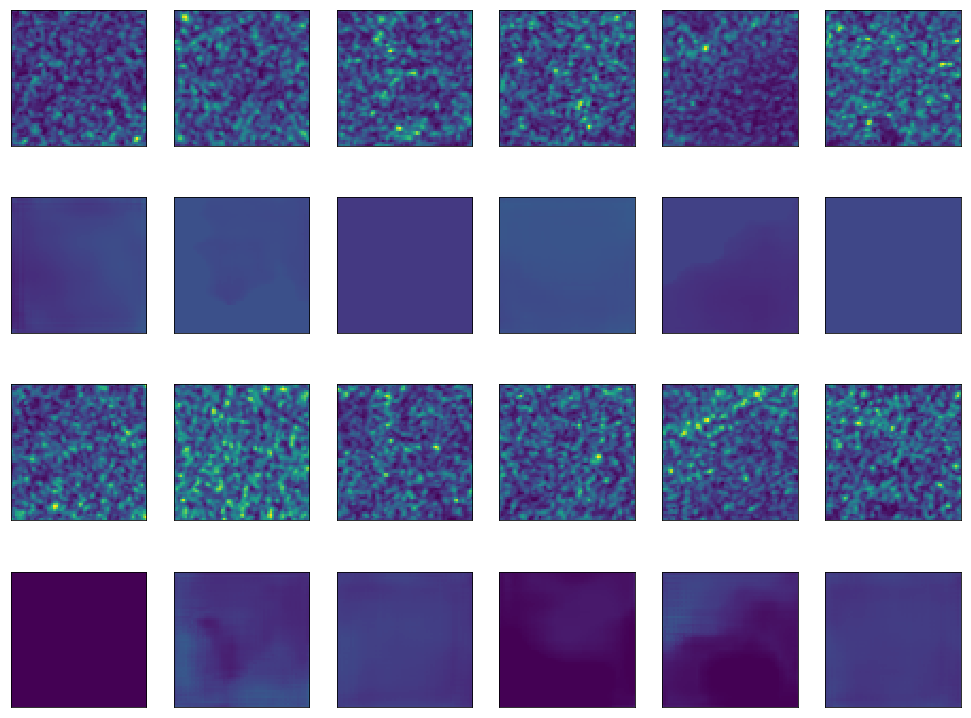

In [128]:
n_rows = 4
n_cols = 6

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 12))

plt.setp(axes.flat, xticks=[], yticks=[])

#predicted = encoder.predict(x_train)
reconstructed = vae2.predict(x_train, batch_size=batch_size)
#reconstructed = generator.predict(x_test_encoded)

s = np.random.randint(55)
i = s
for col in axes.T:
    vv = x_train[i,:,:,1]
    vh = x_train[i,:,:,0]
    vv_rec = reconstructed[i,:,:,1]
    vh_rec = reconstructed[i,:,:,0]
    
    col[0].imshow(vv)
    col[1].imshow(vv_rec)#, clim=(0.0, np.max(vv)))
    col[2].imshow(vh)
    col[3].imshow(vh_rec)# clim=(0.0, np.max(vh)))
    
    i += 1


#i = 0
#for p in predicted[s:][:n_cols]:
#    axes.T[i][1].set_title(str(np.argmax(p)))
#    axes.T[i][3].set_title(str(np.argmax(p)))
#    i += 1
    
fig.subplots_adjust(bottom=0.05, right=0.95)
plt.show()

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])#, c=y_test)
#plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
